In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#copy_cat_sensitivity
nu = .5*np.random.rand(n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([ 7.,  9.,  7., 11., 11., 16., 12.,  9.,  8., 10.]),
 array([0.00088037, 0.05063574, 0.1003911 , 0.15014646, 0.19990182,
        0.24965718, 0.29941254, 0.34916791, 0.39892327, 0.44867863,
        0.49843399]),
 <a list of 10 Patch objects>)

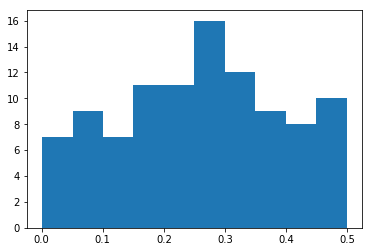

In [4]:
plt.hist(nu)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'copy_wt':[nu],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([ 398.61197663,  231.18219577, 1401.64449161,  616.5479314 ,
        1335.53645361, 1697.32845907, 2422.37637468, 1526.07767456,
         913.00714154, 1332.51288457,  809.16939937,  134.73103146,
         674.62219586, 2199.73979819, 1161.07506634, 2661.89380992,
         911.08058688, 1498.91709776, 1394.53492348,  691.92424253,
        3528.45681726,  395.79860808,  653.51874878, 1639.63155415,
         245.26997953, 2089.69518473,  237.24377992,  366.57160085,
         755.91118235,  423.87060258, 1551.56808269,  873.12851232,
         720.80533443, 1703.50154236,  935.83970037,  346.63590712,
         428.16515378, 3032.79315568,  957.58599773,  125.29969801,
        3179.74837237,  212.59877107, 1132.84275709,  233.67198425,
        4440.17772769,  317.84012137,  814.16304942,  440.57701206,
        1045.12713555, 1188.65700723,  139.48358513,  328.23290388,
         215.43098791,  723.15285166, 1025.63102625, 2009.37550557,
 

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    #can also add a term for extrapolating the trend
    g = params['gains']
    nu = params['copy_wt']
    phat = g*s['funds']/s['supply']*(1-nu)+ nu*s['spot_price']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 1000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 1000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([2.3322122 , 2.18138684, 2.30217504, 2.00551155, 2.70745129,
       1.63889656, 1.67892422, 1.98383077, 2.95902062, 1.5761846 ,
       2.5484157 , 2.94499875, 1.92306483, 2.22818492, 1.79761528,
       2.3582194 , 2.24268385, 1.52364676, 2.93309642, 1.82278493,
       1.69374342, 1.78222283, 2.1606613 , 2.74505866, 1.9184868 ,
       1.37268277, 2.33660842, 1.75584823, 2.29778034, 2.42553826,
       2.18113383, 0.82831746, 1.73569867, 2.72190266, 1.25309   ,
       1.8899775 , 1.94049359, 1.70119962, 2.48187904, 2.09428825,
       0.88293374, 1.79132572, 2.70746969, 2.11596264, 2.62801156,
       0.8914034 , 1.84913997, 1.82913855, 1.84175269, 2.42715056,
       1.55017345, 2.13279951, 1.96808158, 1.42655388, 0.95739562,
       2.34551517, 1.4082954 , 1.6952318 , 1.53690627, 1.61275922,
       1.61674564, 2.58856131, 1.77260435, 2.47428282, 1.92658832,
       1.70956976, 1.296253  , 2.05010348, 2.64358796, 0

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a132cac88>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a132cac88>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

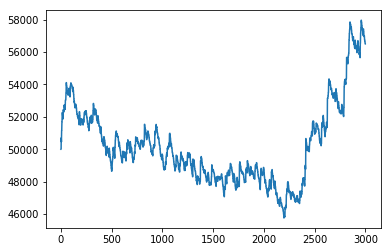

In [21]:
df.funds.plot()

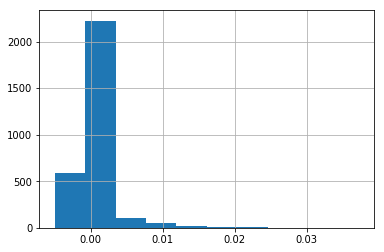

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

In [24]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [25]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [26]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [27]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

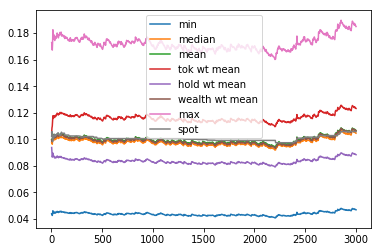

In [28]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

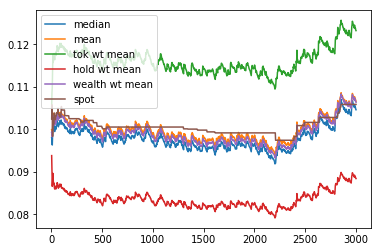

In [29]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

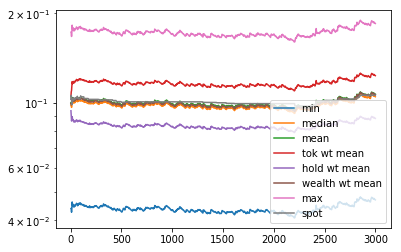

In [30]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [31]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

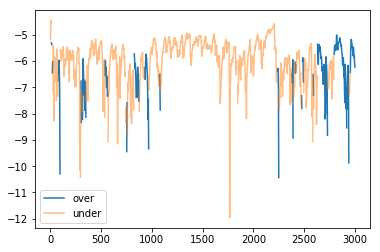

In [32]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [33]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

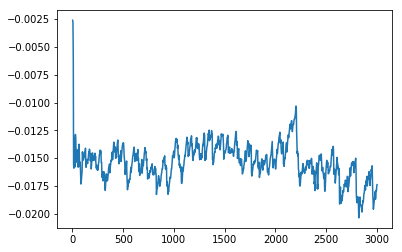

In [34]:
rdf.est_err.plot()

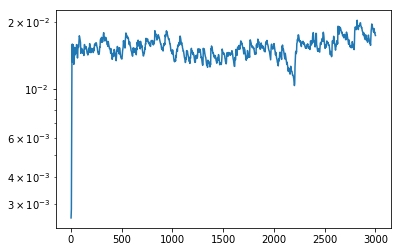

In [35]:
rdf.est_err.apply(np.abs).plot(logy=True)

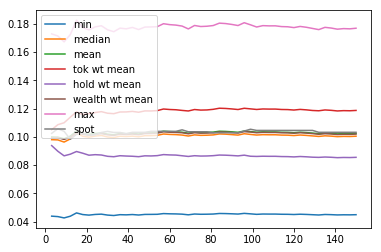

In [36]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

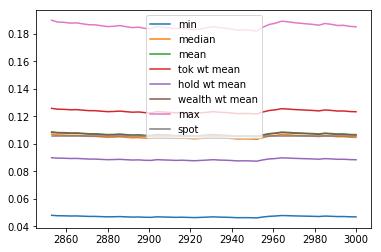

In [37]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [38]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [39]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [40]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [41]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [42]:
tx_summary

pbar                  amt
              median  count        median
agent mech                               
0     bond  0.105442    1.0  3.986120e+02
1     bond  0.101684    1.0  2.311822e+02
2     bond  0.100876    1.0  1.401644e+03
3     bond  0.100758   31.0  2.281013e-10
      burn  0.099208  343.0  7.664643e-10
4     bond  0.104732    1.0  1.335536e+03
5     burn  0.097145    1.0  9.523197e+03
6     burn  0.095980    1.0  9.174460e+03
7     bond  0.102171   10.0  7.326889e-10
      burn  0.101742  114.0  6.024571e-10
8     bond  0.101853    1.0  9.130071e+02
9     burn  0.096991    1.0  7.578023e+03
10    bond  0.099455    1.0  8.091694e+02
11    bond  0.104860    1.0  1.347310e+02
12    bond  0.105210    2.0  2.891141e+02
      burn  0.105399    7.0  1.770688e-09
13    bond  0.100395    1.0  2.199740e+03
14    burn  0.098685    1.0  7.217113e+03
15    bond  0.106560    1.0  2.661894e+03
16    bond  0.102994    1.0  9.110806e+02
17    burn  0.094676    1.0  8.679055e+03
18    bond  0.109309    1.0  1.394535e+03
19    burn  0.094977    1.0  6.906255e+03
20    burn  0.094011    1.0  6.306686e+03
21    burn  0.098091    1.0  6.592497e+03
22    bond  0.099676    1.0  6.535187e+02
23    bond  0.104994    1.0  1.639632e+03
24    bond  0.103977    4.0  3.066104e+02
      burn  0.099516  100.0  1.458612e-09
25    burn  0.099027    1.0  8.056750e+03
...              ...    ...           ...
74    burn  0.099056    1.0  1.372620e+04
75    bond  0.099621    1.0  3.697771e+02
76    bond  0.102448    1.0  6.135282e+02
77    bond  0.099477    1.0  8.041919e+02
78    bond  0.103451    1.0  8.097115e+02
79    burn  0.094842    1.0  1.523043e+04
80    bond  0.101541    1.0  3.130344e+03
81    burn  0.094002    1.0  5.498124e+03
82    burn  0.093433    1.0  5.865291e+03
83    bond  0.100039    2.0  1.329928e+02
      burn  0.109385    1.0  1.074245e-09
84    bond  0.098757    1.0  1.612439e+02
85    bond  0.107848    1.0  1.774553e+03
86    burn  0.095707    1.0  1.090251e+04
87    burn  0.103796    1.0  1.376839e+04
88    burn  0.097806    1.0  9.654153e+03
89    bond  0.102680    1.0  7.796138e+02
90    bond  0.102529    1.0  4.207742e+02
91    burn  0.096459    1.0  4.919176e+03
92    burn  0.094030    1.0  1.303908e+04
93    burn  0.097947    1.0  1.525854e+04
94    burn  0.097189    1.0  8.852259e+03
95    bond  0.104415    1.0  1.871127e+03
96    bond  0.103146    1.0  7.364674e+02
      burn  0.103581   25.0  3.156298e-09
97    bond  0.098549    1.0  9.699573e+02
98    bond  0.104456    3.0  1.824810e-09
      burn  0.100236   75.0  1.702680e-09
99    bond  0.099711    2.0  5.574179e+02
      burn  0.101389    1.0  5.453960e-10

[118 rows x 3 columns]

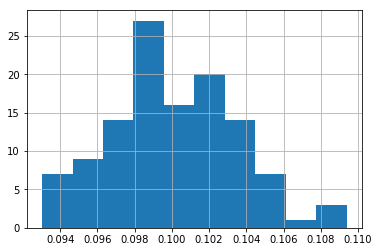

In [43]:
tx_summary.pbar['median'].hist()

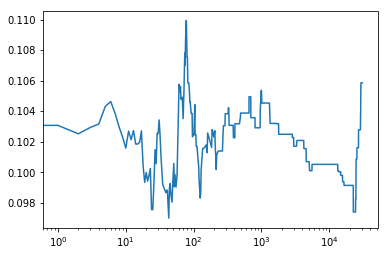

In [44]:
sdf['P'].plot(logx=True)

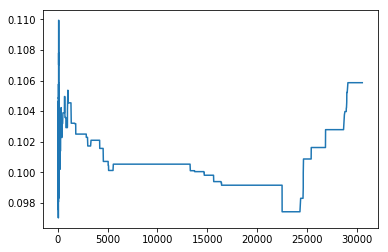

In [45]:
sdf['P'].plot()

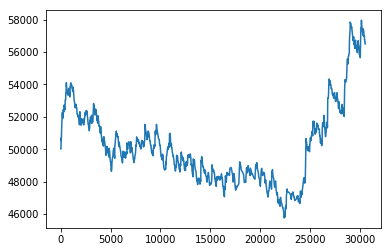

In [46]:
sdf.F.plot()

In [47]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

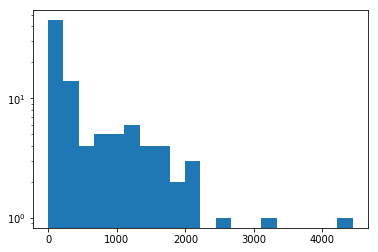

In [48]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

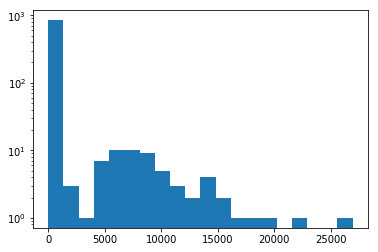

In [49]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [50]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

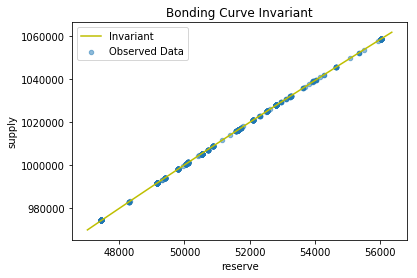

In [51]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [52]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([53.,  9., 16.,  7.,  5.,  6.,  2.,  0.,  1.,  1.]),
 array([   0.        ,  636.42292584, 1272.84585167, 1909.26877751,
        2545.69170334, 3182.11462918, 3818.53755502, 4454.96048085,
        5091.38340669, 5727.80633252, 6364.22925836]),
 <a list of 10 Patch objects>)

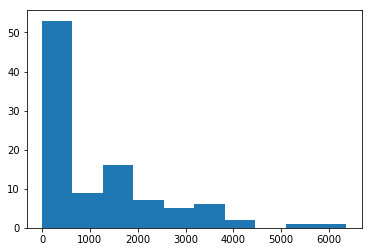

In [53]:
plt.hist(rdf.iloc[-1].holdings)

In [54]:
rdf['gini_h'] = rdf.holdings.apply(gini)

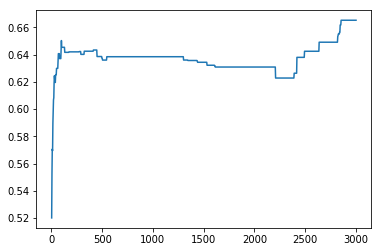

In [55]:
rdf.gini_h.plot()

(array([45.,  9., 16., 11.,  8.,  6.,  3.,  1.,  0.,  1.]),
 array([    0.        ,  5369.33776706, 10738.67553412, 16108.01330117,
        21477.35106823, 26846.68883529, 32216.02660235, 37585.36436941,
        42954.70213647, 48324.03990352, 53693.37767058]),
 <a list of 10 Patch objects>)

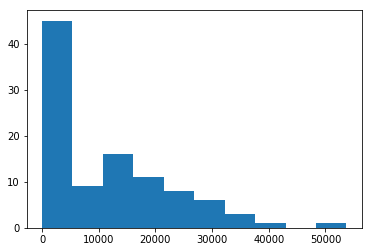

In [56]:
plt.hist(rdf.iloc[-1].tokens)

In [57]:
rdf['gini_s'] = rdf.tokens.apply(gini)

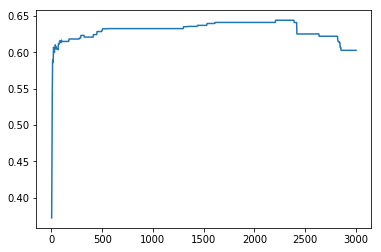

In [58]:
rdf.gini_s.plot()

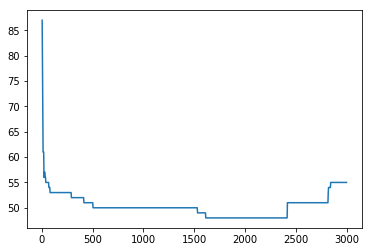

In [59]:
rdf.tokens.apply(np.count_nonzero).plot()

In [60]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([16., 33., 19., 10., 10.,  6.,  3.,  0.,  2.,  1.]),
 array([ 677.78411386, 1246.42862831, 1815.07314276, 2383.71765721,
        2952.36217166, 3521.00668611, 4089.65120056, 4658.29571501,
        5226.94022946, 5795.58474391, 6364.22925836]),
 <a list of 10 Patch objects>)

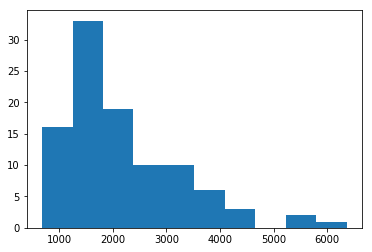

In [61]:
plt.hist(rdf.iloc[-1].asset_value)

In [62]:
rdf['gini'] = rdf.asset_value.apply(gini)

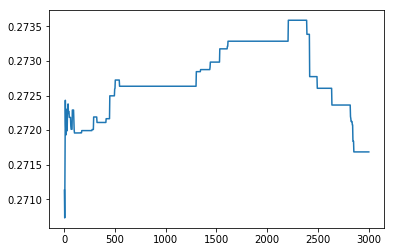

In [63]:
rdf.gini.plot()

In [64]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

([array([ 3., 12., 38., 29., 16.,  1.,  1.]),
  array([ 3., 12., 37., 30., 16.,  1.,  1.]),
  array([ 3., 12., 38., 29., 16.,  1.,  1.]),
  array([ 4., 11., 38., 30., 15.,  1.,  1.]),
  array([ 3., 12., 38., 29., 16.,  1.,  1.]),
  array([ 4., 11., 39., 30., 14.,  1.,  1.]),
  array([ 4., 11., 39., 31., 13.,  1.,  1.])],
 array([-0.55724979, -0.36763523, -0.17802066,  0.01159391,  0.20120847,
         0.39082304,  0.5804376 ,  0.77005217]),
 <a list of 7 Lists of Patches objects>)

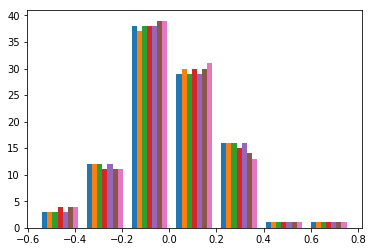

In [65]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)